## QUANTUM AUTOENCODER ##

In [1]:
import time
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import csv
from pennylane import numpy

/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def ansatz(params, n_wires_latent, n_wires_trash):
    init_weights = params[:5]
    init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    weights = params[5:]
    weights = np.reshape(weights, (2, 4, 2))
    weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires_latent+n_wires_trash))

In [3]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [4]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [5]:
dev = qml.device("default.qubit", wires=n_wires_total)

In [6]:
#def quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash):
#    ansatz(init_weights, weights)
#    swap_test(n_wires_latent, n_wires_trash)

In [7]:
def quantum_encoder_train(params, n_wires_latent, n_wires_trash):
    ansatz(params,n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    

In [8]:
@qml.qnode(dev)
def domain_wall(params):
    # Separare i parametri
    #init_weights = params[:5]
    #init_weights = qml.numpy.tensor(init_weights, requires_grad=True)
    #weights = params[5:]
    #weights = np.reshape(weights, (2, 4, 2))
    #weights = qml.numpy.tensor(weights, requires_grad=True)
    qml.X(2)
    qml.X(3)
    qml.X(4)
    quantum_encoder_train(params, n_wires_latent, n_wires_trash)
    # n_wires_latent and n_wires_trash are global variables
    #quantum_encoder_train(init_weights, weights, n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)#, op=qml.PauliZ(7))
    #return qml.expval(qml.Z(7))

In [9]:
initial_point = np.random.random((5,))
#print(np.shape(initial_point))
initial_point = qml.numpy.tensor(initial_point, requires_grad=True)
weights = np.random.random((2, 4, 2))
weights = qml.numpy.tensor(weights, requires_grad=True)
#print(np.shape(weights))
#print(weights)
params = np.concatenate([initial_point, weights.flatten()])
params = qml.numpy.tensor(params, requires_grad=True)
#print(params)
#print(params[:5])

(<Figure size 800x900 with 1 Axes>, <Axes: >)


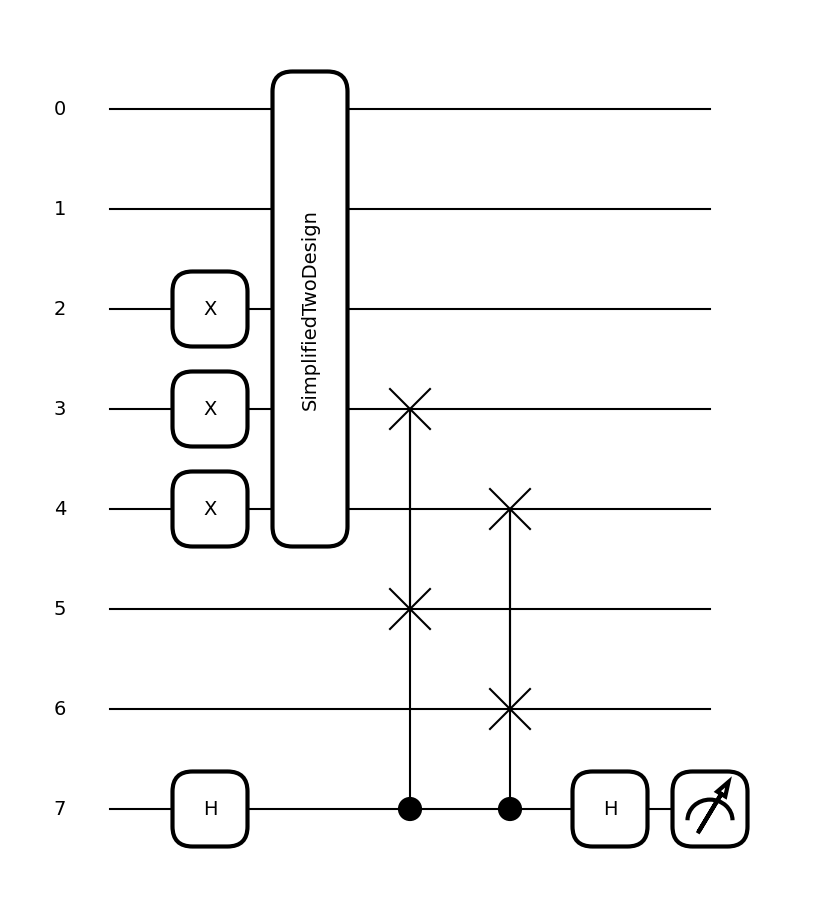

In [10]:
drawer = qml.draw_mpl(domain_wall)
print(drawer(params))

In [11]:
# Definizione della funzione di costo come la somma delle probabilità di misurare 1
def cost_function(params):
    
    # Ottiene le probabilità di misurazione
    probs = domain_wall(params)
    #print(f"Probabilities: {probs}")
    
    # La funzione di costo è la somma delle probabilità di ottenere 1
    cost = probs[1]  # Assumendo che prob[1] rappresenti la probabilità di misurare 1
    #print(f"Probability of measuring 1: {cost}")
    return cost


In [12]:
# Inizializzazione dell'ottimizzatore
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 150
costs = []

# Ciclo di addestramento
start = time.time()
for i in range(steps):
    params, cost_val = opt.step_and_cost(cost_function, params)
    costs.append(cost_val)
    #if i%5==0:
        #print(f"Step {i+1}: cost = {cost_val:.4f}")

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")
# Stampa dei pesi ottimizzati
#print("Pesi ottimizzati:", params)
#opt_weights = params

6.113235235214233


In [13]:
opt_weights = params
print(opt_weights)

[ 0.02384462  0.96668197  0.08164322  1.53858447  0.82155277  0.00952573
  0.94416378  0.23891673 -0.85180028  0.65793194  0.35311003  0.64802092
  1.26622773  0.07979273  0.45172962  0.15071982 -0.11697072  0.19751191
  0.47993174  0.54643688  1.25736546]


In [14]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in weights])


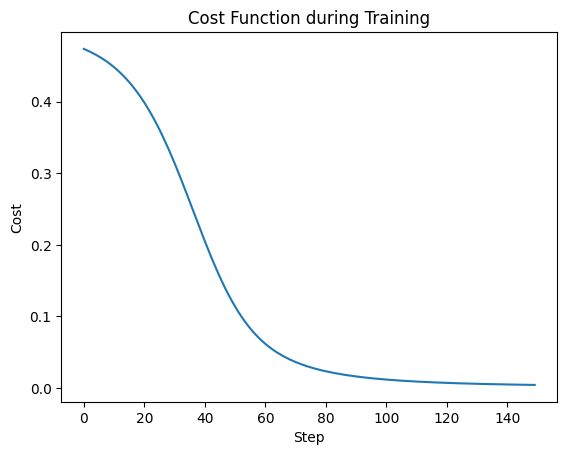

In [15]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(costs)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [16]:
dev_autoencoder = qml.device("default.qubit", wires=n_wires_latent+n_wires_trash)

In [17]:
def reset_to_zero(wir):
    m = qml.measure(wir[0])
    m = qml.measure(wir[1])
    qml.cond(m, qml.PauliX)(wir[0])
    qml.cond(m, qml.PauliX)(wir[1])

In [18]:
@qml.qnode(dev_autoencoder)
def autoencoder(opt_weights):
    qml.X(2)
    qml.X(3)
    qml.X(4)
    ansatz(opt_weights, n_wires_latent, n_wires_trash) 
    #domain_wall(opt_weights)
    wir=[3, 4]
    reset_to_zero(wir)
    qml.adjoint(ansatz)(opt_weights, n_wires_latent, n_wires_trash)
    #return qml.state()
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]


(<Figure size 900x675 with 1 Axes>, <Axes: >)


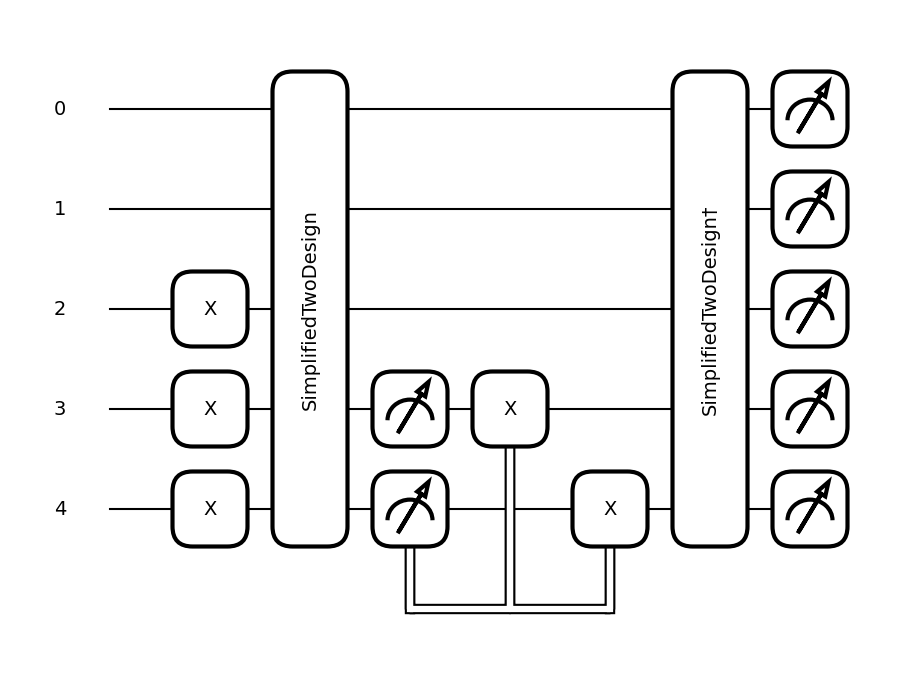

In [19]:
drawer_1 = qml.draw_mpl(autoencoder)
print(drawer_1(opt_weights))

In [20]:
dev_initial = qml.device("default.qubit", wires=5)
@qml.qnode(dev_initial)
def initial_state():
    qml.X(2)
    qml.X(3)
    qml.X(4)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

print(initial_state())

test_state = autoencoder(opt_weights)
print(test_state)
fidelity = np.abs(np.dot(initial_state(), test_state))**2
print("Fidelity of our Output State with our Input State: ", fidelity)

[tensor(1., requires_grad=True), tensor(1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True), tensor(-1., requires_grad=True)]
[tensor(0.99998888, requires_grad=True), tensor(0.97351529, requires_grad=True), tensor(-0.96948419, requires_grad=True), tensor(-0.98390423, requires_grad=True), tensor(-0.98070817, requires_grad=True)]
Fidelity of our Output State with our Input State:  24.084545185862716


In [21]:
def fidelity(initial_state, test_state):    
    for i in range(5):
        f = 0
        f += np.sum(np.abs(initial_state[i] - test_state[i]))**2
    return 1 - f

In [22]:
fidelity = fidelity(initial_state(), test_state)
print(fidelity)

0.9996278253631787
